In [115]:
import random
import numpy as np
import pandas as pd

class LinearRegression:
  def __init__(self, learningRate, max_runs, store_data_rate = 1, scaling_method = 'None', degreeOfPolynomial = 1, lambdaValue = 0):
    self.lr = learningRate
    self.max_runs = max_runs
    self.weights = np.ones(1).reshape(1, 1)
    self.m = 0
    self.cf = 1000
    self.hypothesis = None
    self.data = []
    self.store_data_rate = store_data_rate
    self.scaling_method = scaling_method
    self.degree_of_poly = degreeOfPolynomial
    self.lambdaValue = lambdaValue
    self.feature_means = None
    self.feature_stds = None
    self.feature_mins = None
    self.feature_maxs = None

  def scale_features(self, x):
    if self.scaling_method == 'standardization':
      self.feature_means = np.mean(x, axis=0)
      self.feature_stds = np.std(x, axis=0)
      return (x - self.feature_means) / self.feature_stds
    elif self.scaling_method == 'min_max':
      self.feature_mins = np.min(x, axis=0)
      self.feature_maxs = np.max(x, axis=0)
      return (x - self.feature_mins) / (self.feature_maxs - self.feature_mins)
    elif self.scaling_method == 'None':
      return x
    else:
      raise ValueError("Invalid scaling method.")

  def inverse_scale_features(self, x_scaled):
      if self.scaling_method == 'standardization':
          return x_scaled * self.feature_stds + self.feature_means
      elif self.scaling_method == 'min_max':
          return x_scaled * (self.feature_maxs - self.feature_mins) + self.feature_mins

  def fit_normal(self, x, y):
    x = self.scale_features(x)
    x = self.createPolynomials(x)

    x_T_x = x.T @ x
    x_T_y = x.T @ y

    self.weights = np.linalg.solve(x_T_x, x_T_y).T
    self.hypothesis = np.dot(x, self.weights.T)
    self.cf = self.getCurrentCost(x, y)
    self.data.append({
          'Iteration': 1,
          'Weights': self.weights.flatten().tolist(),
          'Cost': self.cf,
        })

    return self.weights

  def fit(self, x, y):
    x = self.scale_features(x)
    x = self.createPolynomials(x)
    num_rows, num_columns = x.shape
    self.m = num_rows
    self.weights = np.ones(num_columns).reshape(1, num_columns)
    countValue = 0
    samecfValue = 0
    prev_cost = float('inf')

    for i in range(self.max_runs):
      self.hypothesis = np.dot(x, self.weights.T)

      cost = self.calculate_cost(y)
      #print(f"Iteration {i+1}, Cost: {cost}")

      if(np.isclose(cost, prev_cost)):
        samecfValue += 1

        if samecfValue > 10:
          print("Terminating due to same error for too long.")
          return True
      else:
        samecfValue = 0

      self.cf = cost
      self.prev_cost = cost
      countValue += 1

      if(countValue >= self.store_data_rate):
        self.data.append({
          'Iteration': i + 1,
          'Weights': self.weights.flatten().tolist(),
          'Cost': cost,
        })

        countValue = 0

      self.updateWeights(x, y)

  def calculate_cost(self, y):
    # cost function
    error = self.hypothesis - y
    mean_squared_error = np.mean(error ** 2)

    return (0.5 * mean_squared_error) + self.regularizeCost()

  def updateWeights(self, x, y):
    error = self.hypothesis - y
    gradient = np.mean(error * x, axis=0)
    self.weights -= self.lr * (gradient - self.regularizeGD())

  def createPolynomials(self, data):
    degree = self.degree_of_poly
    data_with_new_columns = data.copy()
    for col_index in range(data.shape[1]):
      column_data = data[:, col_index]

      for d in range(2, degree + 1):  # Start from degree 2 up to specified degree
        new_column = column_data ** d
        data_with_new_columns = np.column_stack((data_with_new_columns, new_column))

    data_with_new_columns = np.column_stack((np.ones((data.shape[0], 1)), data_with_new_columns)) #Add the bias term
    return data_with_new_columns

  def regularizeCost(self):
    weights_sum_squared = np.sum(self.weights[0, 1:]**2)  # Sum of squared weights, excluding bias
    return (self.lambdaValue / (2 * self.m)) * weights_sum_squared

  def regularizeGD(self):
    reg_term = (self.lambdaValue / self.m) * self.weights[0, 1:]
    return np.concatenate(([0], reg_term))

  def predict(self, x):
    x = self.scale_features(x)
    x = self.createPolynomials(x)
    return np.dot(x, self.weights.T)

  def get_table(self):
    df = pd.DataFrame(self.data)

    # Expand the Weights column
    weight_df = pd.DataFrame(df['Weights'].tolist(), columns=[f'Weight_{i}' for i in range(len(self.weights[0]))])
    df = pd.concat([df.drop('Weights', axis=1), weight_df], axis=1)

    return df

  def displayWeights(self):
    number = 0
    num_rows, num_columns = self.weights.shape
    print(f"Num of weights are: {num_columns}")

    for weight in self.weights[0]:
      number += 1
      print(f"Weight {number} (Slope): {weight}")

  def getCurrentCost(self, x, y):
    self.m = x.shape[0]
    return self.calculate_cost(y)

In [91]:
def generateDummyData(columns, rows, seed=None):
    # Set the random seed
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed()  # This will use a random seed

    # Generate random data
    X = np.random.rand(rows, columns)  # Generate 'amount' samples with 'xAmount' features

    # Generate coefficients (including intercept)
    true_coefficients = np.random.randn(columns + 1)

    # Generate y with some random noise
    y = np.dot(np.column_stack((np.ones(rows), X)), true_coefficients) + np.random.randn(rows) * 0.1

    return X, y.reshape(-1, 1), true_coefficients

In [118]:
x, y, true_coeff = generateDummyData(5, 800)

LinearRegressor = LinearRegression(learningRate = 0.1, max_runs = 400, store_data_rate = 1, scaling_method = 'standardization', degreeOfPolynomial=2, lambdaValue = 1)
LinearRegressor.fit(x, y)
LinearRegressor.get_table()

,Iteration,Cost,Weight_0,Weight_1,Weight_2,Weight_3,Weight_4,Weight_5,Weight_6,Weight_7,Weight_8,Weight_9,Weight_10
0,1,32.200481,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,5.915128,0.266975,0.880892,0.888140,0.854812,0.889361,0.910770,0.192453,0.184778,0.189717,0.184443,0.176936
2,3,2.590598,0.014419,0.773801,0.774720,0.732356,0.786775,0.840590,-0.069244,-0.078562,-0.082727,-0.082079,-0.095634
3,4,1.861371,-0.079223,0.678399,0.668733,0.625103,0.694105,0.779815,-0.151348,-0.160350,-0.176461,-0.167466,-0.185873
4,5,1.487738,-0.120177,0.593705,0.572311,0.529762,0.611164,0.725048,-0.174732,-0.182806,-0.210254,-0.193203,-0.215454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,0.005077,-1.322355,-0.056491,-0.256346,-0.327840,-0.061048,0.097322,-0.005422,0.001375,-0.003332,0.000931,-0.000154
396,397,0.005077,-1.322485,-0.056490,-0.256342,-0.327843,-0.061047,0.097319,-0.005399,0.001396,-0.003306,0.000952,-0.000132
397,398,0.005077,-1.322613,-0.056490,-0.256339,-0.327846,-0.061046,0.097315,-0.005377,0.001417,-0.003280,0.000974,-0.000110
398,399,0.005076,-1.322739,-0.056490,-0.256335,-0.327848,-0.061045,0.097312,-0.005355,0.001437,-0.003254,0.000995,-0.000088


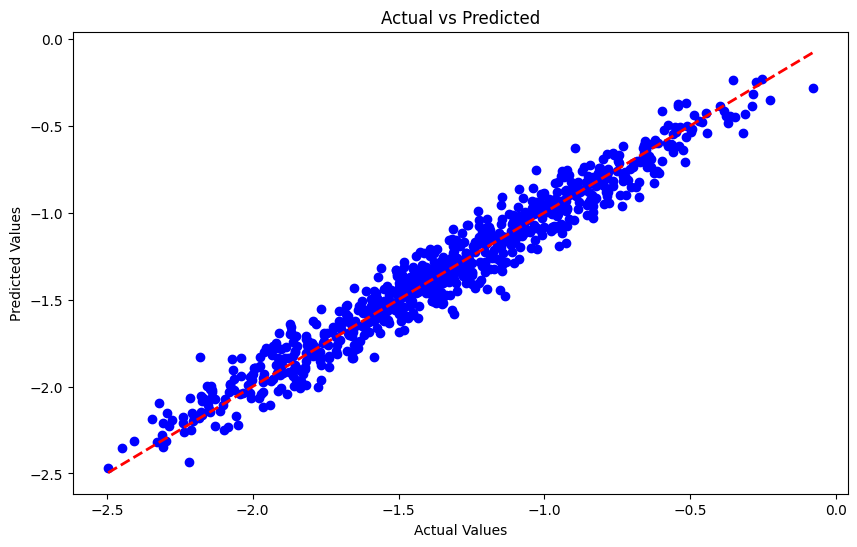

In [119]:
import matplotlib.pyplot as plt
y_pred = LinearRegressor.hypothesis

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()